TODO 
- disorder from alphafold structures
- protein sections matching PDI changes
- count charges AA

In [1]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from data_loading import *
from isoform_pairwise_metrics import *
from plotting import y1h_pdi_per_tf_gene_plot, m1h_activation_per_tf_gene_plot, COLOR_PURPLE
from data_loading import load_annotated_6k_collection, load_y1h_pdi_data


In [2]:
disorder = pd.read_csv('../data/processed/TFiso1_disorder-and-ss_from-alphafold.tsv',
                       sep='\t')
tfs = load_annotated_6k_collection()

# TODO: fix missing data
clones_with_disorder_data = set(disorder['clone_name'].unique())
for tf in tfs.values():
    for iso in tf.cloned_isoforms:
        if iso.name not in clones_with_disorder_data:
            print('missing disorder data for {}'.format(iso.name))
            continue
        iso.disorder = disorder.loc[disorder['clone_name'] == iso.name, 'is_disordered'].values

# sanity check
for tf in tfs.values():
    for iso in tf.cloned_isoforms:
        if hasattr(iso, 'disorder'):
            if len(iso.disorder) != len(iso.aa_seq):
                raise UserWarning('inconsistent amino acid sequence and disordered residues data for {}'.format(iso.name))


def disordered_fraction_of_different_regions(gene, ref_iso_name, alt_iso_name):
    algn = gene.pairwise_changes_relative_to_reference(ref_iso_name, alt_iso_name)
    if not hasattr(gene[ref_iso_name], 'disorder') or not hasattr(gene[alt_iso_name], 'disorder'):
        return np.nan
    ref_iter = iter(gene[ref_iso_name].disorder)
    alt_iter = iter(gene[alt_iso_name].disorder)
    merged_disorder = []
    for pos in algn:
        if pos == 'I':
            merged_disorder.append(next(alt_iter))
        elif pos == 'D':
            merged_disorder.append(next(ref_iter))
        else:
            merged_disorder.append(next(ref_iter))
            next(alt_iter)

    return np.mean([is_disordered for pos, is_disordered in zip(algn, merged_disorder) if pos != 'M'])


disordered_fraction_of_different_regions(tfs['CREB1'], 'CREB1-2', 'CREB1-1')

reading from cache
missing disorder data for ZBTB18-1
missing disorder data for ZBTB18-2
missing disorder data for ZBTB48-1
missing disorder data for PRDM16-1
missing disorder data for PRDM16-2
missing disorder data for RORC-1
missing disorder data for ZBTB49-1
missing disorder data for ZNF655-1
missing disorder data for ZNF655-2
missing disorder data for ZNF212-1
missing disorder data for ZNF212-2
missing disorder data for ZBTB16-1
missing disorder data for ZBTB16-2
missing disorder data for ZBTB44-1
missing disorder data for GLI1-1
missing disorder data for GLI1-2
missing disorder data for GLI1-3
missing disorder data for ZBTB1-1
missing disorder data for ZNF263-1
missing disorder data for E4F1-1
missing disorder data for ZSCAN32-1
missing disorder data for SP2-1
missing disorder data for ZNF18-1
missing disorder data for ZNF473-1
missing disorder data for ZNF341-1
missing disorder data for ZNF341-2
missing disorder data for ZFY-1
missing disorder data for ZFY-2


1.0

In [3]:
# TODO move to isolib
def n_aa_change_from_feature(gene, ref_iso_name, alt_iso_name, domain_start, domain_end):
    algn = gene.pairwise_changes_relative_to_reference(ref_iso_name, alt_iso_name)

    def _coords_transform_aa_seq_to_alignment(i, alignment):
        if i > len(alignment.replace("I", "")):
            raise ValueError("position is not in isoform AA sequence")
        aa_seq_indices = [
            "" if c == "I" else len(alignment[:j].replace("I", ""))
            for j, c in enumerate(alignment)
        ]
        return aa_seq_indices.index(i)
    
    start = _coords_transform_aa_seq_to_alignment(domain_start, algn)
    end = _coords_transform_aa_seq_to_alignment(domain_end - 1, algn) + 1

    if not all(x == 'M' for x in algn[start:end]):
        return 0  # change is within the domain
    
    big_number = 9999999999999999999999999
    c_dist = big_number
    n_dist = big_number
    for i, l in enumerate(reversed(algn[:start])):
        if l != 'M':
            c_dist = i + 1
            break
    for i, l in enumerate(algn[end:]):
        if l != 'M':
            n_dist = i + 1
            break
    if c_dist == big_number and n_dist == big_number:
        raise UserWarning('problem calculating distance')
    return min([c_dist, n_dist])


def n_aa_to_all_features(self, ref_iso_name):
    results = []
    ref_iso = self._orf_dict[ref_iso_name]
    row = {"gene": self.name, "ref_iso": ref_iso_name}
    for aa_feature in ref_iso.aa_seq_features:
        for alt_iso_name, alt_iso in self._orf_dict.items():
            if alt_iso_name == ref_iso_name:
                continue
            row.update(
                {
                    "alt_iso": alt_iso_name,
                    "accession": aa_feature.accession,
                    "category": aa_feature.category,
                    "start_in_ref_iso": aa_feature.start,
                    "end_in_ref_iso": aa_feature.end,
                    "length": aa_feature.end - aa_feature.start,
                }
            )
            row.update({"n_aa_change_to_domain": n_aa_change_from_feature(self, ref_iso_name, alt_iso_name, aa_feature.start, aa_feature.end)})
            results.append(row.copy())
    results = pd.DataFrame(results)
    return results


gene = tfs['TBX5']
ref_iso_name = 'TBX5-1'
alt_iso_name = 'TBX5-3'

#for dom in gene[ref_iso_name].aa_seq_features:
#    print(dom)
#    n = n_aa_change_from_feature(gene, ref_iso_name, alt_iso_name, dom.start, dom.end)
#    print(n)

# get for all domains
# get DBDs
# find min over DBDs

dist = pd.concat([n_aa_to_all_features(g, g.cloned_reference_isoform.name) for g in tfs.values()])
dist['is_DBD'] = dist['accession'].isin(load_dbd_accessions())


In [4]:
y1h = load_y1h_pdi_data()
y1h = y1h.drop_duplicates()  # TODO: why is this here?
n_pdi = (y1h.drop(columns='tf')
            .set_index('unique_acc')
            .sum(axis=1))

In [5]:
tfs = load_annotated_6k_collection()

df = pd.concat([g.aa_feature_disruption(g.cloned_reference_isoform.name) for g in tfs.values()])
df['is_DBD'] = df['accession'].isin(load_dbd_accessions())
df['is_DBD_flank'] = (df['accession'].str.endswith('_flank_N') |
                      df['accession'].str.endswith('_flank_C'))
df_new = (df.loc[df['is_DBD'], :]
        .groupby(['gene', 'ref_iso', 'alt_iso'])
        [['deletion', 'frameshift']].sum()
        .sum(axis=1) / df.loc[df['is_DBD'], :]
        .groupby(['gene', 'ref_iso', 'alt_iso'])
        ['length'].sum()).to_frame(name='dbd_fraction')

df_new['dbd_insertion_n_aa'] = (df.loc[df['is_DBD'], :]
                                  .groupby(['gene', 'ref_iso', 'alt_iso'])
                                  ['insertion']
                                  .sum())

df_new['dbd_n_aa_to_change'] = (dist.loc[dist['is_DBD'], :]
                                  .groupby(['gene', 'ref_iso', 'alt_iso'])
                                  ['n_aa_change_to_domain']
                                  .min())
        
# flank affected
df_new['dbd_flank_affected'] = (df.loc[df['is_DBD_flank'], :]
        .groupby(['gene', 'ref_iso', 'alt_iso'])
        [['deletion', 'insertion', 'frameshift']].sum()
        .sum(axis=1) > 0)
df = df_new.reset_index()
df['dbd_pct_lost'] = df['dbd_fraction'] * 100.


def dbd_affected_categories(pct_lost):
    if pct_lost < 0:
        raise ValueError('negative percent value')
    elif pct_lost == 0:
        return 'Full DBD in\nalternative isoform'
    elif pct_lost >= 100:
        return 'Full loss\nof DBD'
    else:
        return 'Partial loss\nof DBD'

df['dbd_affected'] = df['dbd_pct_lost'].apply(dbd_affected_categories)
df['dbd_or_flank_affected'] = df['dbd_affected']
df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') &
       df['dbd_flank_affected'], 'dbd_or_flank_affected'] = 'DBD flank affected'

isoforms = load_valid_isoform_clones()
y1h = load_y1h_pdi_data()
y1h = y1h.drop_duplicates()  # TODO: why is this here?
n_pdi = (y1h.drop(columns='tf')
            .set_index('unique_acc')
            .sum(axis=1))
n_pdi.index = n_pdi.index.map(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

# map each isoform to change in PDI vs reference
def delta_pdi(row):
    iso_acc = row['alt_iso']
    ref_acc = row['ref_iso']
    if iso_acc == ref_acc:
        return np.nan
    n_ref = n_pdi.get(ref_acc, np.nan)
    n_iso = n_pdi.get(iso_acc, np.nan)
    if n_ref == 0:
        return np.nan
    return (n_iso - n_ref) / n_ref


df['delta_pdi'] = df.apply(delta_pdi, axis=1)
df = df.dropna(subset=['delta_pdi'])

df['tf_family'] = df['gene'].map(lambda x: tfs[x].tf_family)
df['delta_pdi_trunc'] = df['delta_pdi'].clip(upper=1)

if (((df['dbd_fraction'] > 0) | (df['dbd_insertion_n_aa'] > 0)) & (df['dbd_n_aa_to_change'] > 0)).any():
    raise UserWarning('something wrong with calculations')
if ((df['dbd_fraction'] == 0) & (df['dbd_insertion_n_aa'] == 0) & (df['dbd_n_aa_to_change'] == 0)).any():
    raise UserWarning('something wrong with calculations')

reading from cache


In [6]:
df.loc[df['dbd_insertion_n_aa'] > 0 ]

,gene,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,delta_pdi,tf_family,delta_pdi_trunc
72,DLX4,DLX4-1,DLX4-3,0.245614,26,0,True,24.561404,Partial loss\nof DBD,Partial loss\nof DBD,-1.000000,Homeodomain,-1.000000
204,HEY1,HEY1-2,HEY1-1,0.000000,4,0,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-0.666667,bHLH,-0.666667
252,KLF7,KLF7-1,KLF7-4,0.000000,1,0,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.000000,C2H2 ZF,-1.000000
288,MAX,MAX-1,MAX-5,0.346154,39,0,True,34.615385,Partial loss\nof DBD,Partial loss\nof DBD,-1.000000,bHLH,-1.000000
289,MAX,MAX-1,MAX-6,0.346154,39,0,True,34.615385,Partial loss\nof DBD,Partial loss\nof DBD,-1.000000,bHLH,-1.000000
505,RFX4,RFX4-1,RFX4-3,0.873418,32,0,True,87.341772,Partial loss\nof DBD,Partial loss\nof DBD,-1.000000,RFX,-1.000000


In [7]:
# count
print(len(tfs), 'TF genes')
print(sum([len(tf.orfs[0].aa_seq_features) > 0 for tf in tfs.values()]),
      'TF genes with at least one Pfam domain in longest cloned isoform')
print(sum([len(tf.orfs[0].dna_binding_domains) > 0 for tf in tfs.values()]))
tfs_no_dbd = {k: v for k, v in tfs.items()
              if len(v.orfs[0].dna_binding_domains) == 0
              and len(v.orfs[0].aa_seq_features) > 0}

309 TF genes
301 TF genes with at least one Pfam domain in longest cloned isoform
273


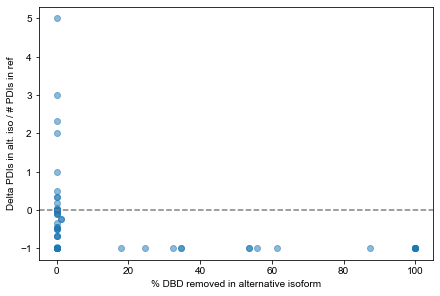

In [8]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df['dbd_pct_lost'].values,
           df['delta_pdi'].values,
           alpha=0.5)
ax.axhline(0, linestyle='--', color='grey')
ax.set_ylabel('Delta PDIs in alt. iso / # PDIs in ref')
ax.set_xlabel('% DBD removed in alternative isoform')
plt.savefig('../figures/DBD_change_vs_PDI_scatter.pdf', 
            bbox_inches='tight')

In [9]:
df.sort_values('delta_pdi', ascending=False).head()

,gene,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,delta_pdi,tf_family,delta_pdi_trunc
277,LHX9,LHX9-1,LHX9-3,0.0,0,250,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,5.000000,Homeodomain,1.0
511,RORC,RORC-3,RORC-4,0.0,0,5,True,0.0,Full DBD in\nalternative isoform,DBD flank affected,3.000000,Nuclear receptor,1.0
71,DLX4,DLX4-1,DLX4-2,0.0,0,24,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,2.333333,Homeodomain,1.0
273,LHX9,LHX9-1,LHX9-2,0.0,0,141,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,2.000000,Homeodomain,1.0
487,RARG,RARG-1,RARG-2,0.0,0,27,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,1.000000,Nuclear receptor,1.0


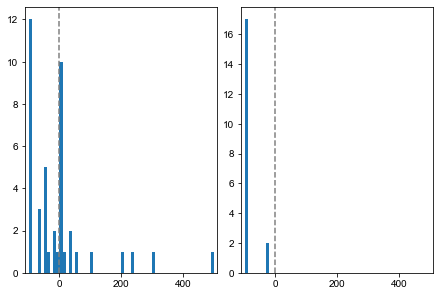

In [10]:
fig, axes = plt.subplots(1, 2)
axes[0].hist(df.loc[df['dbd_pct_lost'] == 0, 'delta_pdi'].values * 100,
             range=(-100, 500), bins=6*10)
axes[1].hist(df.loc[df['dbd_pct_lost'] > 0, 'delta_pdi'].values * 100,
             range=(-100, 500), bins=6*10)
for ax in axes:
    ax.axvline(0, linestyle='--', color='grey')
    ax.set_xlim(-110, 510)

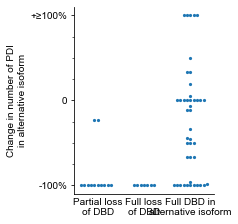

In [11]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3.2, 3)
df['delta_pdi_trunc'] = df['delta_pdi'].clip(upper=1)
sns.swarmplot(data=df, 
              y='delta_pdi_trunc', 
              x='dbd_affected',
              size=3.2,
              ax=ax,
              alpha=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel('')
ax.set_yticks([-1, 0, 1])
ax.set_yticks(np.linspace(-1, 1, 9), minor=True)
ax.set_yticklabels(['-100%', '0', '+≥100%'])
ax.invert_xaxis()
ax.set_ylabel('Change in number of PDI\nin alternative isoform')
plt.savefig('../figures/DBD_change_vs_PDI_truncated_inverted.pdf', bbox_inches='tight')

In [12]:
df['dbd_or_flank_affected'].value_counts().index.values

array(['Full DBD in\nalternative isoform', 'Partial loss\nof DBD',
       'DBD flank affected', 'Full loss\nof DBD'], dtype=object)

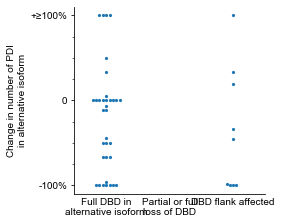

In [13]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3.8, h=3)
df['delta_pdi_trunc'] = df['delta_pdi'].clip(upper=1)
sns.swarmplot(data=df, 
              y='delta_pdi_trunc', 
              x='dbd_or_flank_affected',
              size=3.2,
              order=['Full DBD in\nalternative isoform',
                     'Partial or full\nloss of DBD',
                     'DBD flank affected'],
              ax=ax,
              alpha=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.xaxis.set_tick_params(length=0)
ax.set_xlabel('')
ax.set_yticks([-1, 0, 1])
ax.set_yticks(np.linspace(-1, 1, 9), minor=True)
ax.set_yticklabels(['-100%', '0', '+≥100%'])
ax.set_ylabel('Change in number of PDI\nin alternative isoform')
plt.savefig('../figures/DBD_or_flank_change_vs_PDI_truncated_inverted.pdf', bbox_inches='tight')

In [14]:
df['tf_family_merged'] = df['tf_family'].map(lambda x: x if x in ['C2H2 ZF', 'bHLH', 'Homeodomain', 'Nuclear receptor'] else 'other')

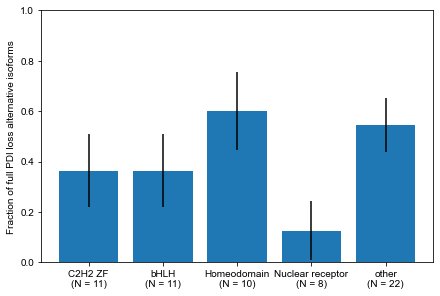

In [15]:
# fraction of 0 PDI alternative isoforms by family
df['full_PDI_loss'] = (df['delta_pdi_trunc'] == -1)
tf_families = ['C2H2 ZF', 'bHLH', 'Homeodomain', 'Nuclear receptor', 'other']
fs = [df.loc[df['tf_family_merged'] == fam, 'full_PDI_loss'].mean() for fam in tf_families]
ns = [(df['tf_family_merged'] == fam).sum() for fam in tf_families]
es = [np.sqrt((f * (1 - f)) / n) for f, n in zip(fs, ns)]

fig, ax = plt.subplots(1, 1)
ax.bar(x=[fam + f'\n(N = {n})' for fam, n in zip(tf_families, ns)],
            height=fs,
            yerr=es)
ax.set_ylim(0, 1)
ax.set_ylabel('Fraction of full PDI loss alternative isoforms')
fig.savefig('../figures/full-PDI-loss-alternative-isoforms-by-family.pdf',
            bbox_inches='tight')

In [16]:

# TODO: move to data_loading.py
dis = pd.read_csv('../data/processed/TFiso1_disorder-and-ss_from-alphafold.tsv',
                  sep='\t')
n_aa = dis.groupby('clone_name').size().rename('n_aa').to_frame()
n_aa['n_aa_disordered'] = dis.groupby('clone_name')['is_disordered'].sum()
n_aa['n_aa_ordered'] = n_aa['n_aa'] - n_aa['n_aa_disordered']
for c in n_aa.columns:
    df[f'delta_{c}'] = df['ref_iso'].map(n_aa[c]) - df['alt_iso'].map(n_aa[c])
    df[f'abs_delta_{c}'] = df[f'delta_{c}'].abs()

In [17]:
df['f_disorder_delta_aa'] = df['abs_delta_n_aa_disordered'] / (df['abs_delta_n_aa_disordered'] + df['abs_delta_n_aa_ordered'])

<AxesSubplot: xlabel='pdi_affected', ylabel='abs_delta_n_aa_ordered'>

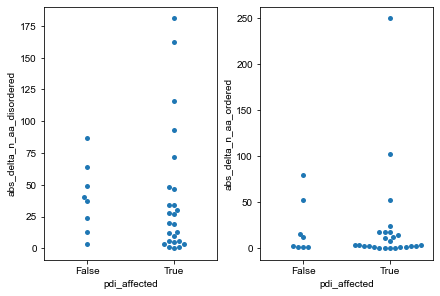

In [18]:
df['pdi_affected'] = (df['delta_pdi'] != 0)
# for isoforms with full DBD + flanks, split by PDI affected vs not
# and plot changes in sequence, disorder and charged residues
fig, axs = plt.subplots(1, 2)
sns.swarmplot(data=df.loc[df['dbd_or_flank_affected'] == 'Full DBD in\nalternative isoform',
                          :],
              x='pdi_affected',
              y='abs_delta_n_aa_disordered',
              ax=axs[0]
)
sns.swarmplot(data=df.loc[df['dbd_or_flank_affected'] == 'Full DBD in\nalternative isoform',
                          :],
              x='pdi_affected',
              y='abs_delta_n_aa_ordered',
              ax=axs[1]
)

<AxesSubplot: xlabel='pdi_affected', ylabel='f_disorder_delta_aa'>

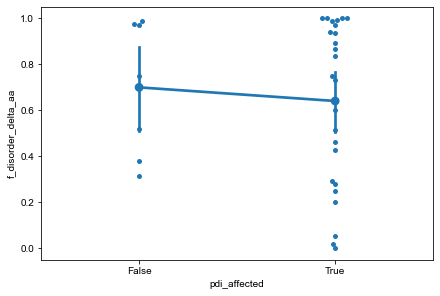

In [19]:
fig, ax = plt.subplots(1, 1)
sns.swarmplot(data=df.loc[df['dbd_or_flank_affected'] == 'Full DBD in\nalternative isoform',
                          :],
              x='pdi_affected',
              y='f_disorder_delta_aa',
              ax=ax
)
sns.pointplot(data=df.loc[df['dbd_or_flank_affected'] == 'Full DBD in\nalternative isoform',
                          :],
              x='pdi_affected',
              y='f_disorder_delta_aa',
              ax=ax
)

In [20]:
#charged_aas = ("K", "R", "H", "D", "E", "C", "Y")

def delta_n_K_or_R(row):
    aa_ref = tfs[row['gene']][row['ref_iso']].aa_seq
    aa_alt = tfs[row['gene']][row['alt_iso']].aa_seq
    return  (aa_alt.count('K') + aa_alt.count('R')) - (aa_ref.count('K') + aa_ref.count('R'))

df['delta_n_K_or_R'] = df.apply(delta_n_K_or_R, axis=1)

In [21]:
# for alternative isoforms, containing the DBD, that are associated with a change in 
# DNA binding vs staying the same, is there a positively charged region in the different 
# amino acid sequence?

# three categories: lose, same, gain
# variable is max postive charged residue count in 10aa sliding window, 

# NOTE I've updated this since the copy and paste from domain/motif notebook
def isoform_specific_regions(gene, subset=None):
    """The name is a bit misleading because it's not specific to one isoform but just
       not common to all isoforms.

    Returns: dict(frozenset: list(str)): isoform IDs and list of contiguous AA sequences
                                         that map to them only 

    """
    algn = gene.genomic_alignment_of_aa_seqs(subset=subset)
    subset_prev = None
    isr = {}
    len_algn = len(list(algn.values())[0])
    for i in range(len_algn):
        subset = frozenset({k for k, v in algn.items() if v[i] != '-'})  # the isoforms that have an aa at that genomic position
        if subset_prev is None:
            if (len(subset) < len(algn)) and (len(subset) > 0):
                start = i
                subset_prev = subset
        else:
            if subset != subset_prev:
                if (len(subset_prev) < len(algn)) and (len(subset_prev) > 0):
                    subseq = (algn[list(subset_prev)[0]][start:i], start, i)
                    isr[subset_prev] = isr.get(subset_prev, []) + [subseq]
                start = i
                subset_prev = subset
            elif  i == (len_algn - 1):
                if (len(subset_prev) < len(algn)) and (len(subset_prev) > 0):
                    subseq = (algn[list(subset_prev)[0]][start:], start, i + 1)
                    isr[subset_prev] = isr.get(subset_prev, []) + [subseq]
                start = i
                subset_prev = subset
    merged = {}
    for iso_subset, subseqs in isr.items():
        merged[iso_subset] = []
        prev_end = np.inf
        prev_subseq = ''
        for subseq, start, end in subseqs:
            if start <= prev_end + 2:
                prev_subseq += subseq
                prev_end = end
            else:
                if prev_subseq != '':
                    merged[iso_subset].append(prev_subseq)
                prev_subseq = subseq
                prev_end = end
        merged[iso_subset].append(prev_subseq)
    merged
    return merged

def count_K_or_R_sliding_window(row, window_size=6):
    # get different amino acid sequence regions
    specific_aa_regions = isoform_specific_regions(tfs[row['gene']], subset=[row['ref_iso'], row['alt_iso']])
    aa_seq_regions_in_ref_not_in_alt = specific_aa_regions.get(frozenset([row['ref_iso']]), [])
    aa_seq_regions_in_alt_not_in_ref = specific_aa_regions.get(frozenset([row['alt_iso']]), [])
    max_count = 0
    for aa_seq in aa_seq_regions_in_ref_not_in_alt:
        for i in range(len(aa_seq) - window_size):
            count = aa_seq[i:i + window_size].count('K') + aa_seq[i:i + window_size].count('R')
            if count > max_count:
                max_count = count
    return max_count

df['count_K_or_R_sliding_window'] = df.apply(count_K_or_R_sliding_window, axis=1)

In [22]:
df['count_K_or_R_sliding_window'].value_counts()

0    16
4    15
3    14
2     9
1     8
Name: count_K_or_R_sliding_window, dtype: int64

In [23]:
df['dbd_or_flank_affected'].value_counts()

Full DBD in\nalternative isoform    34
Partial loss\nof DBD                12
DBD flank affected                   9
Full loss\nof DBD                    7
Name: dbd_or_flank_affected, dtype: int64

In [24]:
# only isoforms with DBD
# three categories: lose, same, gain
# variable is max postive charged residue count in 10aa sliding window,
a = df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') &
            (df['delta_pdi'] < 0),
        'count_K_or_R_sliding_window'].values
b = df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') &
            (df['delta_pdi'] == 0),
        'count_K_or_R_sliding_window'].values
print(a)
print(b)
print(a.mean())
print(b.mean())
print(stats.mannwhitneyu(a, b))

[0 1 0 0 0 0 1 4 4 3 2 2 0 3 3 3 1 3 1 2 0 0 0 2]
[3 0 3 3 1 0 0 0 0]
1.4583333333333333
1.1111111111111112
MannwhitneyuResult(statistic=124.0, pvalue=0.510083571603853)


In [25]:
isoform_specific_regions(tfs['KLF7'], subset=['KLF7-1', 'KLF7-4'])

{frozenset({'KLF7-1'}): ['MDVLASYSIFQELQLVHDTGYFSALPSLEETWQQ'],
 frozenset({'KLF7-4'}): ['M', 'G']}

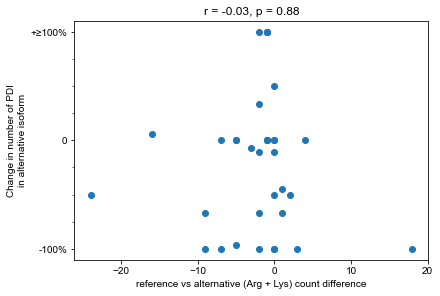

In [26]:
y, x = df.loc[df['dbd_or_flank_affected'] == 'Full DBD in\nalternative isoform',
             ['delta_pdi_trunc', 'delta_n_K_or_R']].values.T

fig, ax = plt.subplots(1, 1)
ax.set_title('r = {:.2f}, p = {:.2f}'.format(*stats.pearsonr(x, y)))
ax.scatter(x=x, y=y)
ax.set_xlabel('reference vs alternative (Arg + Lys) count difference')
ax.set_yticks([-1, 0, 1])
ax.set_yticks(np.linspace(-1, 1, 9), minor=True)
ax.set_yticklabels(['-100%', '0', '+≥100%'])
ax.set_ylabel('Change in number of PDI\nin alternative isoform')
fig.savefig('../figures/PDI-change-vs-Arg-Lys-count-diff_full-DBD-and-flanks-proteins_scatter.pdf',
            bbox_inches='tight')

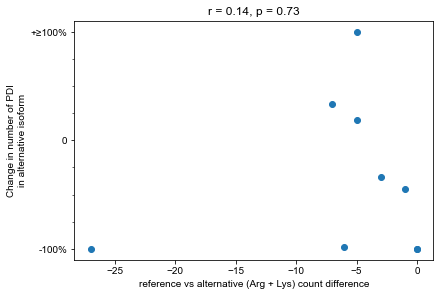

In [27]:
y, x = df.loc[df['dbd_or_flank_affected'] == 'DBD flank affected',
             ['delta_pdi_trunc', 'delta_n_K_or_R']].values.T

fig, ax = plt.subplots(1, 1)
ax.set_title('r = {:.2f}, p = {:.2f}'.format(*stats.pearsonr(x, y)))
ax.scatter(x=x, y=y)
ax.set_xlabel('reference vs alternative (Arg + Lys) count difference')
ax.set_yticks([-1, 0, 1])
ax.set_yticks(np.linspace(-1, 1, 9), minor=True)
ax.set_yticklabels(['-100%', '0', '+≥100%'])
ax.set_ylabel('Change in number of PDI\nin alternative isoform')
fig.savefig('../figures/PDI-change-vs-Arg-Lys-count-diff_DBD-flank-affected-proteins_scatter.pdf',
            bbox_inches='tight')

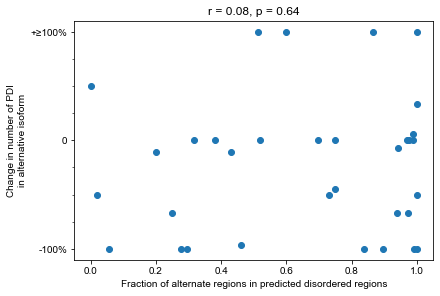

In [28]:
y, x = df.loc[df['dbd_or_flank_affected'] == 'Full DBD in\nalternative isoform',
             ['delta_pdi_trunc', 'f_disorder_delta_aa']].dropna().values.T

fig, ax = plt.subplots(1, 1)
ax.set_title('r = {:.2f}, p = {:.2f}'.format(*stats.pearsonr(x, y)))
ax.scatter(x=x, y=y)
ax.set_xlabel('Fraction of alternate regions in predicted disordered regions')
ax.set_yticks([-1, 0, 1])
ax.set_yticks(np.linspace(-1, 1, 9), minor=True)
ax.set_yticklabels(['-100%', '0', '+≥100%'])
ax.set_ylabel('Change in number of PDI\nin alternative isoform')
fig.savefig('../figures/PDI-change-vs-disordered-fraction-of-alternate-regions_full-DBD-and-flanks-proteins_scatter.pdf',
            bbox_inches='tight')

In [29]:
# check for family enrichment of DBD unaffected PDI changes
df.loc[(df['dbd_or_flank_affected'] == 'Full DBD in\nalternative isoform') &
(df['delta_pdi'] != 0), 'tf_family'].value_counts()

bHLH                7
Homeodomain         5
Nuclear receptor    4
STAT                2
AP-2                2
bZIP                1
Ets                 1
C2H2 ZF             1
SMAD                1
T-box               1
Name: tf_family, dtype: int64

In [30]:
df.loc[(df['dbd_or_flank_affected'] == 'Full DBD in\nalternative isoform') &
(df['delta_pdi'] != 0), 'gene'].value_counts()

TCF4      3
TFAP2A    2
LHX9      2
STAT3     2
PPARG     2
CREB1     1
NFIX      1
TBX5      1
RARG      1
PRRX1     1
MYF6      1
DLX4      1
MLX       1
MEOX1     1
MAX       1
KLF7      1
HEY1      1
FLI1      1
THRA      1
Name: gene, dtype: int64

In [31]:
# PPIs with other TFs as a predictor for non-DBD related PDI changes?

In [32]:
# 15 aa flanks
' '.join(df.loc[(df['dbd_fraction'] == 0) &
       (df['dbd_flank_affected'] == False) &
       (df['delta_pdi'] != 0), 'gene'].unique())

'CREB1 DLX4 FLI1 HEY1 KLF7 LHX9 MAX MEOX1 MLX MYF6 NFIX PPARG PRRX1 RARG STAT3 TBX5 TCF4 TFAP2A THRA'

In [33]:
(df['dbd_pct_lost'] > 0).sum()

19

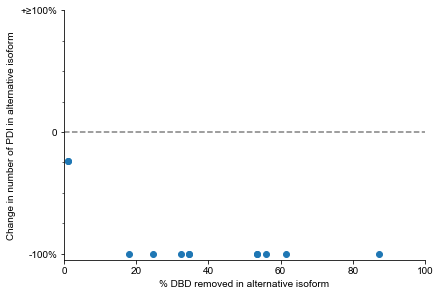

In [34]:
fig, ax = plt.subplots(1, 1)
ax.scatter(df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'dbd_pct_lost'].values,
           df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'delta_pdi_trunc'].values,
           alpha=1)
ax.axhline(0, linestyle='--', color='grey')

ax.set_xlabel('% DBD removed in alternative isoform')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0, 100)
ax.set_yticks([-1, 0, 1])
ax.set_yticks(np.linspace(-1, 1, 9), minor=True)
ax.set_yticklabels(['-100%', '0', '+≥100%'])
ax.set_ylabel('Change in number of PDI in alternative isoform')
plt.savefig('../figures/DBD_change_vs_PDI_scatter_only_partially_affected.pdf', 
            bbox_inches='tight')

In [35]:
df.sort_values('delta_pdi', ascending=False).head()

,gene,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,delta_pdi,tf_family,delta_pdi_trunc,tf_family_merged,full_PDI_loss,delta_n_aa,abs_delta_n_aa,delta_n_aa_disordered,abs_delta_n_aa_disordered,delta_n_aa_ordered,abs_delta_n_aa_ordered,f_disorder_delta_aa,pdi_affected,delta_n_K_or_R,count_K_or_R_sliding_window
277,LHX9,LHX9-1,LHX9-3,0.0,0,250,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,5.000000,Homeodomain,1.0,Homeodomain,False,9.0,9.0,27.0,27.0,-18.0,18.0,0.600000,True,-2,1
511,RORC,RORC-3,RORC-4,0.0,0,5,True,0.0,Full DBD in\nalternative isoform,DBD flank affected,3.000000,Nuclear receptor,1.0,Nuclear receptor,False,21.0,21.0,6.0,6.0,15.0,15.0,0.285714,True,-5,2
71,DLX4,DLX4-1,DLX4-2,0.0,0,24,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,2.333333,Homeodomain,1.0,Homeodomain,False,72.0,72.0,72.0,72.0,0.0,0.0,1.000000,True,-1,2
273,LHX9,LHX9-1,LHX9-2,0.0,0,141,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,2.000000,Homeodomain,1.0,Homeodomain,False,1.0,1.0,19.0,19.0,-18.0,18.0,0.513514,True,-1,0
487,RARG,RARG-1,RARG-2,0.0,0,27,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,1.000000,Nuclear receptor,1.0,Nuclear receptor,False,11.0,11.0,13.0,13.0,-2.0,2.0,0.866667,True,-1,2


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:231: RuntimeWarning: All-NaN slice encountered
  native_width = np.nanmin(np.diff(unique_values))
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:231: RuntimeWarning: All-NaN slice encountered
  native_width = np.nanmin(np.diff(unique_values))
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:231: RuntimeWarning: All-NaN slice encountered
  native_width = np.nanmin(np.diff(unique_values))


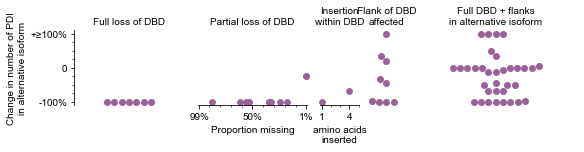

In [36]:
# TODO
# check y variable now that we use reference isoform
# horizontal line across whole

fig, axs = plt.subplots(nrows=1, 
                        ncols=5,
                        sharey=True,
                        width_ratios=[1, 1, 0.35, 0.4, 1.5])
fig.set_size_inches(w=8, h=2)
point_size = 7

axs[0].set_title('Full loss of DBD',
fontsize=10)
sns.swarmplot(data=df,
              y='delta_pdi_trunc', 
              x='dbd_or_flank_affected',
              size=point_size,
              order=[
                     'Full loss\nof DBD',
                     ],
              ax=axs[0],
              color=COLOR_PURPLE,
              alpha=1)

axs[1].set_title('Partial loss of DBD',
fontsize=10)
axs[1].scatter(df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'dbd_pct_lost'].values,
               df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2/1.5,  # I don't think there should be a divide by anything here....
            color=COLOR_PURPLE,
           clip_on=False)
axs[1].set_xlabel('Proportion missing')
axs[1].set_xlim(100, 0)
axs[1].set_xticks([99, 50, 1])
axs[1].set_xticklabels(['{}%'.format(x)for x in axs[1].get_xticks()])
axs[1].set_xticks(range(10, 91, 10), minor=True)


axs[2].set_title('Insertion\nwithin DBD',
fontsize=10)
axs[2].scatter(df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_insertion_n_aa'] > 0), 'dbd_insertion_n_aa'].values,
               df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_insertion_n_aa'] > 0), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2/1.5,  # I don't think there should be a divide by anything here....
            color=COLOR_PURPLE,
           clip_on=False)
axs[2].set_xlabel('amino acids\ninserted')
axs[2].set_xticks([1, 4])
axs[2].set_xticks(range(1, 6), minor=True)

axs[3].set_title('Flank of DBD\naffected',
                 fontsize=10)
sns.swarmplot(data=df,
              y='delta_pdi_trunc', 
              x='dbd_or_flank_affected',
              size=point_size,
              order=[
                     'DBD flank affected',
                     ],
              ax=axs[3],
            color=COLOR_PURPLE,
              alpha=1)

axs[4].set_title('Full DBD + flanks\nin alternative isoform',
fontsize=10)
sns.swarmplot(data=df,
              y='delta_pdi_trunc', 
              x='dbd_or_flank_affected',
              size=point_size,
              order=[
                     'Full DBD in\nalternative isoform',
                     ],
            color=COLOR_PURPLE,
              ax=axs[4],
              alpha=1)

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
for i in [0, 3, 4]:
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].spines['bottom'].set_visible(False)
    axs[i].xaxis.set_tick_params(length=0)
    axs[i].set_xticks([])
axs[0].set_yticks([-1, 0, 1])
axs[0].set_yticks(np.linspace(-1, 1, 9), minor=True)
axs[0].set_yticklabels(['-100%', '0', '+≥100%'])
axs[0].set_ylabel('Change in number of PDI\nin alternative isoform')

plt.savefig('../figures/DBD_or_flank_change_vs_PDI_composite.pdf', bbox_inches='tight')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:231: RuntimeWarning: All-NaN slice encountered
  native_width = np.nanmin(np.diff(unique_values))


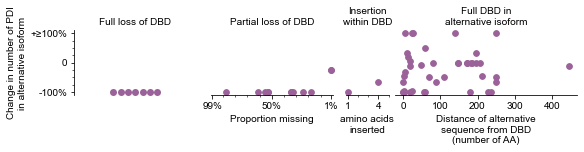

In [37]:
# try distance from DBD
# TODO
# check y variable now that we use reference isoform
# horizontal line across whole

fig, axs = plt.subplots(nrows=1, 
                        ncols=4,
                        sharey=True,
                        width_ratios=[1, 1, 0.35, 1.5])
fig.set_size_inches(w=8, h=2)
point_size = 7

axs[0].set_title('Full loss of DBD',
fontsize=10)
sns.swarmplot(data=df,
              y='delta_pdi_trunc', 
              x='dbd_or_flank_affected',
              size=point_size,
              order=[
                     'Full loss\nof DBD',
                     ],
              ax=axs[0],
              color=COLOR_PURPLE,
              alpha=1)

axs[1].set_title('Partial loss of DBD',
fontsize=10)
axs[1].scatter(df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'dbd_pct_lost'].values,
               df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2/1.5,  # I don't think there should be a divide by anything here....
            color=COLOR_PURPLE,
           clip_on=False)
axs[1].set_xlabel('Proportion missing')
axs[1].set_xlim(100, 0)
axs[1].set_xticks([99, 50, 1])
axs[1].set_xticklabels(['{}%'.format(x)for x in axs[1].get_xticks()])
axs[1].set_xticks(range(10, 91, 10), minor=True)


axs[2].set_title('Insertion\nwithin DBD',
fontsize=10)
axs[2].scatter(df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_insertion_n_aa'] > 0), 'dbd_insertion_n_aa'].values,
               df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_insertion_n_aa'] > 0), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2/1.5,  # I don't think there should be a divide by anything here....
            color=COLOR_PURPLE,
           clip_on=False)
axs[2].set_xlabel('amino acids\ninserted')
axs[2].set_xticks([1, 4])
axs[2].set_xticks(range(1, 6), minor=True)

axs[3].set_title('Full DBD in\nalternative isoform', fontsize=10)
axs[3].scatter(df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform'), 'dbd_n_aa_to_change'].values,
               df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform'), 'delta_pdi_trunc'].values,
           alpha=1,
           s=point_size**2/1.5,  # I don't think there should be a divide by anything here....
            color=COLOR_PURPLE,
           clip_on=False)
axs[3].set_xlabel('Distance of alternative\nsequence from DBD\n(number of AA)')
#axs[3].set_xlim(100, 0)
#axs[3].set_xticks([99, 50, 1])
#axs[3].set_xticklabels(['{}%'.format(x)for x in axs[1].get_xticks()])
#axs[3].set_xticks(range(10, 91, 10), minor=True)


for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
for ax in axs[1:]:
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_tick_params(which='both', length=0)
for i in [0]:
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].spines['bottom'].set_visible(False)
    axs[i].xaxis.set_tick_params(length=0)
    axs[i].set_xticks([])
axs[0].set_yticks([-1, 0, 1])
axs[0].set_yticks(np.linspace(-1, 1, 9), minor=True)
axs[0].set_yticklabels(['-100%', '0', '+≥100%'])
axs[0].set_ylabel('Change in number of PDI\nin alternative isoform')

plt.savefig('../figures/DBD_or_flank_change_vs_PDI_composite_alt_with_distance.pdf', bbox_inches='tight')

In [38]:
# full DBD in alternative isoform, fraction in disordered
df['f_disorder_difference'] = df.apply(lambda x: disordered_fraction_of_different_regions(tfs[x['gene']], x['ref_iso'], x['alt_iso']), axis=1)

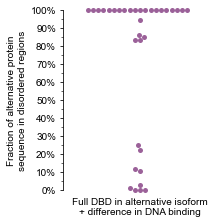

In [39]:
# check low values
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.set_size_inches(h=3, w=3)
sns.swarmplot(data=df.loc[(df['dbd_affected'] == 'Full DBD in\nalternative isoform') & (df['delta_pdi_trunc'] != 0), :],
              y='f_disorder_difference',
              color=COLOR_PURPLE,
              ax=ax,
              clip_on=False,
              #alpha=0.5  # TMP - to check no overlap
              )
ax.set_xlabel('Full DBD in alternative isoform\n+ difference in DNA binding')
ax.set_ylabel('Fraction of alternative protein\nsequence in disordered regions')
ax.set_xticks([])
for loc in ['top', 'bottom', 'right']:
    ax.spines[loc].set_visible(False)
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 21), minor=True)
ax.set_ylim(0, 1)
ax.set_yticklabels(['{:.0%}'.format(y) for y in ax.get_yticks()])
fig.savefig('../figures/disordered-pct-alt-sequence_alt-isoforms-full-DBD-diff-PDI_dotplot.pdf',
            bbox_inches='tight')

In [40]:
# DEBUG
df.sort_values('f_disorder_difference', ascending=True).head(10)

,gene,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,delta_pdi,tf_family,delta_pdi_trunc,tf_family_merged,full_PDI_loss,delta_n_aa,abs_delta_n_aa,delta_n_aa_disordered,abs_delta_n_aa_disordered,delta_n_aa_ordered,abs_delta_n_aa_ordered,f_disorder_delta_aa,pdi_affected,delta_n_K_or_R,count_K_or_R_sliding_window,f_disorder_difference
273,LHX9,LHX9-1,LHX9-2,0.000000,0,141,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,2.000000,Homeodomain,1.000000,Homeodomain,False,1.0,1.0,19.0,19.0,-18.0,18.0,0.513514,True,-1,0,0.000000
204,HEY1,HEY1-2,HEY1-1,0.000000,4,0,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-0.666667,bHLH,-0.666667,bHLH,False,-4.0,4.0,-1.0,1.0,-3.0,3.0,0.250000,True,1,0,0.000000
361,NFIX,NFIX-1,NFIX-2,0.000000,0,59,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,0.500000,SMAD,0.500000,other,False,8.0,8.0,0.0,0.0,8.0,8.0,0.000000,True,0,0,0.000000
563,STAT3,STAT3-1,STAT3-3,0.000000,0,227,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.000000,STAT,-1.000000,other,True,97.0,97.0,-6.0,6.0,103.0,103.0,0.055046,True,-9,3,0.010101
252,KLF7,KLF7-1,KLF7-4,0.000000,1,0,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.000000,C2H2 ZF,-1.000000,C2H2 ZF,True,32.0,32.0,-20.0,20.0,52.0,52.0,0.277778,True,0,0,0.027778
471,PPARG,PPARG-1,PPARG-4,0.000000,0,69,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-0.500000,Nuclear receptor,-0.500000,Nuclear receptor,False,255.0,255.0,5.0,5.0,250.0,250.0,0.019608,True,-24,3,0.107692
470,PPARG,PPARG-1,PPARG-3,0.000000,0,2,True,0.000000,Full DBD in\nalternative isoform,DBD flank affected,-1.000000,Nuclear receptor,-1.000000,Nuclear receptor,True,245.0,245.0,25.0,25.0,220.0,220.0,0.102041,True,-27,3,0.114286
334,NFATC1,NFATC1-1,NFATC1-2,0.180124,0,0,True,18.012422,Partial loss\nof DBD,Partial loss\nof DBD,-1.000000,Rel,-1.000000,other,True,77.0,77.0,-21.0,21.0,98.0,98.0,0.176471,True,-2,4,0.127389
251,KLF7,KLF7-1,KLF7-3,0.000000,0,185,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,0.000000,C2H2 ZF,0.000000,C2H2 ZF,False,28.0,28.0,-24.0,24.0,52.0,52.0,0.315789,False,0,0,0.150000
90,EBF1,EBF1-1,EBF1-2,0.535032,0,0,True,53.503185,Partial loss\nof DBD,Partial loss\nof DBD,-1.000000,EBF1,-1.000000,other,True,183.0,183.0,-4.0,4.0,187.0,187.0,0.020942,True,-22,3,0.189189


In [41]:
# could also do number of aa different or aa similarity
df.loc[df['gene'] == 'TBX5']

,gene,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,delta_pdi,tf_family,delta_pdi_trunc,tf_family_merged,full_PDI_loss,delta_n_aa,abs_delta_n_aa,delta_n_aa_disordered,abs_delta_n_aa_disordered,delta_n_aa_ordered,abs_delta_n_aa_ordered,f_disorder_delta_aa,pdi_affected,delta_n_K_or_R,count_K_or_R_sliding_window,f_disorder_difference
572,TBX5,TBX5-1,TBX5-2,0.0,0,6,True,0.0,Full DBD in\nalternative isoform,DBD flank affected,-0.333333,T-box,-0.333333,other,False,50.0,50.0,41.0,41.0,9.0,9.0,0.820000,True,-3,1,0.860000
573,TBX5,TBX5-1,TBX5-3,0.0,0,90,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-0.666667,T-box,-0.666667,other,False,169.0,169.0,181.0,181.0,-12.0,12.0,0.937824,True,-9,2,0.948357


In [42]:
df.sort_values('dbd_n_aa_to_change', ascending=False).head(10)

,gene,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,delta_pdi,tf_family,delta_pdi_trunc,tf_family_merged,full_PDI_loss,delta_n_aa,abs_delta_n_aa,delta_n_aa_disordered,abs_delta_n_aa_disordered,delta_n_aa_ordered,abs_delta_n_aa_ordered,f_disorder_delta_aa,pdi_affected,delta_n_K_or_R,count_K_or_R_sliding_window,f_disorder_difference
583,TCF4,TCF4-1,TCF4-2,0.0,0,445,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-0.111111,bHLH,-0.111111,bHLH,False,1.0,1.0,-3.0,3.0,4.0,4.0,0.428571,True,0,0,1.000000
277,LHX9,LHX9-1,LHX9-3,0.0,0,250,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,5.000000,Homeodomain,1.000000,Homeodomain,False,9.0,9.0,27.0,27.0,-18.0,18.0,0.600000,True,-2,1,1.000000
663,THRA,THRA-2,THRA-1,0.0,0,249,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-0.500000,Nuclear receptor,-0.500000,Nuclear receptor,False,-41.0,41.0,-30.0,30.0,-11.0,11.0,0.731707,True,2,2,0.247934
143,FLI1,FLI1-1,FLI1-2,0.0,0,249,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-0.666667,Ets,-0.666667,other,False,33.0,33.0,34.0,34.0,-1.0,1.0,0.971429,True,-2,1,1.000000
561,STAT3,STAT3-1,STAT3-2,0.0,0,237,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.000000,STAT,-1.000000,other,True,47.0,47.0,47.0,47.0,0.0,0.0,1.000000,True,0,1,1.000000
563,STAT3,STAT3-1,STAT3-3,0.0,0,227,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.000000,STAT,-1.000000,other,True,97.0,97.0,-6.0,6.0,103.0,103.0,0.055046,True,-9,3,0.010101
634,TFAP2A,TFAP2A-2,TFAP2A-1,0.0,0,211,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-0.444444,AP-2,-0.444444,other,False,-2.0,2.0,-3.0,3.0,1.0,1.0,0.750000,True,1,0,1.000000
144,FLI1,FLI1-1,FLI1-3,0.0,0,206,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,0.000000,Ets,0.000000,other,False,66.0,66.0,64.0,64.0,2.0,2.0,0.969697,False,-5,3,1.000000
636,TFAP2A,TFAP2A-2,TFAP2A-4,0.0,0,196,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,0.333333,AP-2,0.333333,other,False,6.0,6.0,6.0,6.0,0.0,0.0,1.000000,True,-2,1,1.000000
635,TFAP2A,TFAP2A-2,TFAP2A-3,0.0,0,196,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,0.000000,AP-2,0.000000,other,False,4.0,4.0,3.0,3.0,1.0,1.0,0.750000,False,-1,1,1.000000


In [43]:
iso = tfs['HEY1']['HEY1-2']
iso.aa_seq[iso.aa_seq_features[0].start:iso.aa_seq_features[0].end]

'RKRRRGIIEKRRRDRINNSLSELRRLVPSAFEKQGSAKLEKAEILQMTVDHLKMLH'

In [44]:
iso = tfs['ZIC3']['ZIC3-2']
iso.aa_seq[iso.aa_seq_features[0].start:iso.aa_seq_features[0].end]

'RQPIKQELSCKWIDEAQLSRPKKSCDRTFSTMHELVTHVTMEHVGGPEQNNHVCYWEECPREGKSFKAKYKLVNHIRVHTGEKPFPCPFPGCGKIFARSENLKIHKRTHTGEKPFKCEFEGCDRRFANSSDRKKHMHVHTSDKPYICKVCDKSYTHPSSLRKHMKVH'

In [45]:
len(iso.aa_seq)

467

In [46]:
(1060+164) / 3

408.0

In [47]:
iso = tfs['ZIC3']['ZIC3-2']
(iso.aa_seq_features[0].start, iso.aa_seq_features[0].end)

(243, 410)

In [48]:
iso = tfs['HEY1']['HEY1-2']
(iso.aa_seq_features[0].start, iso.aa_seq_features[0].end)

(49, 105)

In [49]:
tfs['HEY1'].pairwise_changes_relative_to_reference('HEY1-2', 'HEY1-1').find('I')

83

In [50]:
tfs['CREB1'].pairwise_changes_relative_to_reference('CREB1-2', 'CREB1-1').find('I')

87

In [51]:
iso = tfs['CREB1']['CREB1-1']
(iso.aa_seq_features[1].start, iso.aa_seq_features[1].end)

(280, 340)

In [52]:
iso = tfs['KLF7']['KLF7-1']
print(iso.aa_seq_features[0].start, iso.aa_seq_features[0].end)
iso.aa_seq[iso.aa_seq_features[0].start:iso.aa_seq_features[0].end]

218 301


'HRCQFNGCRKVYTKSSHLKAHQRTHTGEKPYKCSWEGCEWRFARSDELTRHYRKHTGAKPFKCNHCDRCFSRSDHLALHMKRH'

In [53]:
iso = tfs['KLF7']['KLF7-4']
print(iso.aa_seq_features[0].start, iso.aa_seq_features[0].end)

185 269


In [54]:
print(tfs['KLF7'].pairwise_changes_relative_to_reference('KLF7-1', 'KLF7-4').rfind('I'))
tfs['KLF7'].pairwise_changes_relative_to_reference('KLF7-1', 'KLF7-4')

246


'DDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDIMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMIMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM'

In [55]:
# closest PDB with DNA for HEY1 is 4H10 chain A (ARNTL) sequence ID 59%

In [56]:
df.loc[(df['dbd_pct_lost'] > 0) & (df['dbd_pct_lost'] < 100) & (df['delta_pdi_trunc'] > -1), :]

,gene,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,delta_pdi,tf_family,delta_pdi_trunc,tf_family_merged,full_PDI_loss,delta_n_aa,abs_delta_n_aa,delta_n_aa_disordered,abs_delta_n_aa_disordered,delta_n_aa_ordered,abs_delta_n_aa_ordered,f_disorder_delta_aa,pdi_affected,delta_n_K_or_R,count_K_or_R_sliding_window,f_disorder_difference
726,ZIC3,ZIC3-2,ZIC3-1,0.011976,0,0,True,1.197605,Partial loss\nof DBD,Partial loss\nof DBD,-0.235294,C2H2 ZF,-0.235294,C2H2 ZF,False,57.0,57.0,65.0,65.0,-8.0,8.0,0.890411,True,-2,2,0.952381
728,ZIC3,ZIC3-2,ZIC3-3,0.011976,0,0,True,1.197605,Partial loss\nof DBD,Partial loss\nof DBD,-0.235294,C2H2 ZF,-0.235294,C2H2 ZF,False,11.0,11.0,14.0,14.0,-3.0,3.0,0.823529,True,0,2,1.000000


In [57]:
tfs['ZIC3']['ZIC3-2'].aa_seq_features

[ZF_array: C2H2_ZF_array_5 C2H2_ZF_array_5 244-410,
 DBD_flank: C2H2_ZF_array_5_flank_N N_DBD_flank 229-243,
 DBD_flank: C2H2_ZF_array_5_flank_C C_DBD_flank 411-425]

In [58]:
df.head()

,gene,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,delta_pdi,tf_family,delta_pdi_trunc,tf_family_merged,full_PDI_loss,delta_n_aa,abs_delta_n_aa,delta_n_aa_disordered,abs_delta_n_aa_disordered,delta_n_aa_ordered,abs_delta_n_aa_ordered,f_disorder_delta_aa,pdi_affected,delta_n_K_or_R,count_K_or_R_sliding_window,f_disorder_difference
32,CREB1,CREB1-2,CREB1-1,0.000000,0,180,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.000000,bZIP,-1.0,other,True,-14.0,14.0,10.0,10.0,-24.0,24.0,0.294118,True,3,0,1.000000
70,DLX1,DLX1-1,DLX1-2,1.000000,0,0,True,100.000000,Full loss\nof DBD,Full loss\nof DBD,-1.000000,Homeodomain,-1.0,Homeodomain,True,126.0,126.0,74.0,74.0,52.0,52.0,0.587302,True,-19,4,0.653333
71,DLX4,DLX4-1,DLX4-2,0.000000,0,24,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,2.333333,Homeodomain,1.0,Homeodomain,False,72.0,72.0,72.0,72.0,0.0,0.0,1.000000,True,-1,2,1.000000
72,DLX4,DLX4-1,DLX4-3,0.245614,26,0,True,24.561404,Partial loss\nof DBD,Partial loss\nof DBD,-1.000000,Homeodomain,-1.0,Homeodomain,True,126.0,126.0,112.0,112.0,14.0,14.0,0.888889,True,-10,4,0.887387
73,DLX5,DLX5-1,DLX5-2,1.000000,0,0,True,100.000000,Full loss\nof DBD,Full loss\nof DBD,-1.000000,Homeodomain,-1.0,Homeodomain,True,141.0,141.0,78.0,78.0,63.0,63.0,0.553191,True,-15,4,0.631579


In [59]:
df.loc[(df['dbd_pct_lost'] == 0) & (df['dbd_flank_affected'] == False) & (df['delta_pdi_trunc'] > -1), :].sort_values('delta_pdi').tail()

,gene,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,delta_pdi,tf_family,delta_pdi_trunc,tf_family_merged,full_PDI_loss,delta_n_aa,abs_delta_n_aa,delta_n_aa_disordered,abs_delta_n_aa_disordered,delta_n_aa_ordered,abs_delta_n_aa_ordered,f_disorder_delta_aa,pdi_affected,delta_n_K_or_R,count_K_or_R_sliding_window,f_disorder_difference
361,NFIX,NFIX-1,NFIX-2,0.0,0,59,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,0.500000,SMAD,0.5,other,False,8.0,8.0,0.0,0.0,8.0,8.0,0.000000,True,0,0,0.0
487,RARG,RARG-1,RARG-2,0.0,0,27,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,1.000000,Nuclear receptor,1.0,Nuclear receptor,False,11.0,11.0,13.0,13.0,-2.0,2.0,0.866667,True,-1,2,1.0
273,LHX9,LHX9-1,LHX9-2,0.0,0,141,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,2.000000,Homeodomain,1.0,Homeodomain,False,1.0,1.0,19.0,19.0,-18.0,18.0,0.513514,True,-1,0,0.0
71,DLX4,DLX4-1,DLX4-2,0.0,0,24,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,2.333333,Homeodomain,1.0,Homeodomain,False,72.0,72.0,72.0,72.0,0.0,0.0,1.000000,True,-1,2,1.0
277,LHX9,LHX9-1,LHX9-3,0.0,0,250,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,5.000000,Homeodomain,1.0,Homeodomain,False,9.0,9.0,27.0,27.0,-18.0,18.0,0.600000,True,-2,1,1.0


In [60]:
df.head()

,gene,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,delta_pdi,tf_family,delta_pdi_trunc,tf_family_merged,full_PDI_loss,delta_n_aa,abs_delta_n_aa,delta_n_aa_disordered,abs_delta_n_aa_disordered,delta_n_aa_ordered,abs_delta_n_aa_ordered,f_disorder_delta_aa,pdi_affected,delta_n_K_or_R,count_K_or_R_sliding_window,f_disorder_difference
32,CREB1,CREB1-2,CREB1-1,0.000000,0,180,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.000000,bZIP,-1.0,other,True,-14.0,14.0,10.0,10.0,-24.0,24.0,0.294118,True,3,0,1.000000
70,DLX1,DLX1-1,DLX1-2,1.000000,0,0,True,100.000000,Full loss\nof DBD,Full loss\nof DBD,-1.000000,Homeodomain,-1.0,Homeodomain,True,126.0,126.0,74.0,74.0,52.0,52.0,0.587302,True,-19,4,0.653333
71,DLX4,DLX4-1,DLX4-2,0.000000,0,24,False,0.000000,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,2.333333,Homeodomain,1.0,Homeodomain,False,72.0,72.0,72.0,72.0,0.0,0.0,1.000000,True,-1,2,1.000000
72,DLX4,DLX4-1,DLX4-3,0.245614,26,0,True,24.561404,Partial loss\nof DBD,Partial loss\nof DBD,-1.000000,Homeodomain,-1.0,Homeodomain,True,126.0,126.0,112.0,112.0,14.0,14.0,0.888889,True,-10,4,0.887387
73,DLX5,DLX5-1,DLX5-2,1.000000,0,0,True,100.000000,Full loss\nof DBD,Full loss\nof DBD,-1.000000,Homeodomain,-1.0,Homeodomain,True,141.0,141.0,78.0,78.0,63.0,63.0,0.553191,True,-15,4,0.631579


In [61]:
df.loc[df['dbd_insertion_n_aa'] == 1]

,gene,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,delta_pdi,tf_family,delta_pdi_trunc,tf_family_merged,full_PDI_loss,delta_n_aa,abs_delta_n_aa,delta_n_aa_disordered,abs_delta_n_aa_disordered,delta_n_aa_ordered,abs_delta_n_aa_ordered,f_disorder_delta_aa,pdi_affected,delta_n_K_or_R,count_K_or_R_sliding_window,f_disorder_difference
252,KLF7,KLF7-1,KLF7-4,0.0,1,0,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.0,C2H2 ZF,-1.0,C2H2 ZF,True,32.0,32.0,-20.0,20.0,52.0,52.0,0.277778,True,0,0,0.027778


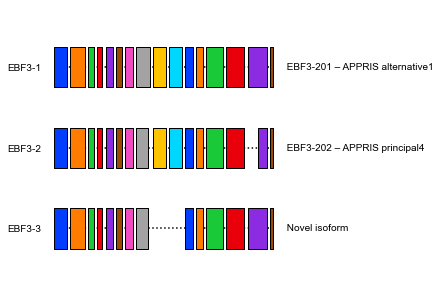

In [62]:
tfs['EBF3'].exon_diagram()

In [63]:
m1h = load_m1h_activation_data()

In [64]:
y1h.head()

,tf,unique_acc,HS1022,HS1043,HS1067,HS1139,HS1142,HS118,HS1181,HS1185,HS1199,HS1208,HS1242,HS1271,HS129,HS1315,HS1329,HS1339,HS135,HS1419,HS1436,HS1480,HS149,HS151,HS1516,HS1551,HS1597,HS162,HS1657,HS169,HS170,HS1707,HS174,HS181,HS1811,HS1833,HS1867,HS189,HS194,HS20,HS204,HS2048,HS205,HS2062,HS2081,HS213,HS215,HS218,HS238,HS240,...,MUT_32,MUT_36,MUT_37,MUT_40,MUT_41,MUT_46,MUT_64,MUT_75,CCL14,CCL15,CCL20,CCL24,CCL28,CCL3L1,CCL4,CCL5,CCL8,CSF1,CXCL10,CXCL17,CXCL2,CXCL3,CXCL5,IFNK,IFNL1,IFNL4,IL10,IL12A,IL17A,IL17F,IL21,IL25,IL26,IL3,IL31,IL32,IL33,IL34,IL36A,IL37,KITLG,LTA,PF4V1,TNFSF10,TNFSF13,TNFSF14,TNFSF4,TNFSF8,XCL1,XCL2
162,CREB1,CREB1|1/2|02E01,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
0,CREB1,CREB1|2/2|01F12,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,DLX1,DLX1|1/2|07A12,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
174,DLX1,DLX1|2/2|07E09,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,DLX4,DLX4|1/3|11A04,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [65]:
m1h.head()

,gene,clone_acc,M1H_rep1,M1H_rep2,M1H_rep3
360,AEBP2,AEBP2|2/3|05F03,0.241019,0.189211,0.473661
359,AEBP2,AEBP2|3/3|05E07,-0.276303,-0.305477,-0.121186
0,ARNT2,ARNT2|1/6|08C12,4.498733,4.501519,4.297244
1,ARNT2,ARNT2|2/6|09E01,2.407721,2.407411,2.197963
3,ARNTL2,ARNTL2|2/5|12C06,0.398027,0.391809,0.299461


In [66]:
# TODO: move to per TF gene notebook
for gene_name, tf in tfs.items():
    if gene_name in y1h['tf'].values:
        y1h_pdi_per_tf_gene_plot(gene_name, y1h)
        plt.savefig('../figures/per_gene/y1h_profile/{}_y1h_profile.pdf'.format(gene_name),
                    bbox_inches='tight')
        plt.close(plt.gcf())
    if gene_name in m1h['gene'].values:
        m1h_activation_per_tf_gene_plot(gene_name, m1h)
        plt.savefig('../figures/per_gene/m1h_profile/{}_m1h_profile.pdf'.format(gene_name),
                   bbox_inches='tight')
        plt.close(plt.gcf())
    tf.exon_diagram()
    plt.savefig('../figures/per_gene/exon_diagram/{}_exon_diagram.pdf'.format(gene_name),
                bbox_inches='tight')
    plt.close(plt.gcf())

<ipython-input-66-b2fb03153e71>:14: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('../figures/per_gene/exon_diagram/{}_exon_diagram.pdf'.format(gene_name),
<ipython-input-66-b2fb03153e71>:14: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('../figures/per_gene/exon_diagram/{}_exon_diagram.pdf'.format(gene_name),
<ipython-input-66-b2fb03153e71>:14: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('../figures/per_gene/exon_diagram/{}_exon_diagram.pdf'.format(gene_name),
<ipython-input-66-b2fb03153e71>:14: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('../figures/per_gene/exon_diag

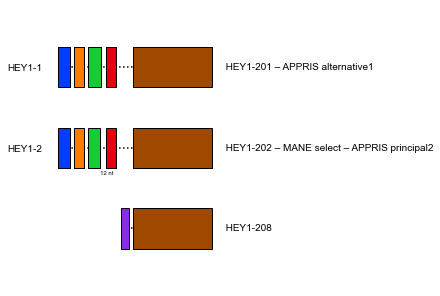

In [67]:
tfs['HEY1'].exon_diagram()

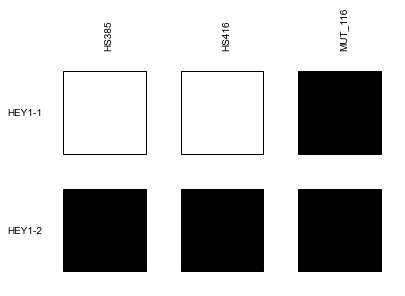

In [68]:
y1h_pdi_per_tf_gene_plot('HEY1', y1h)

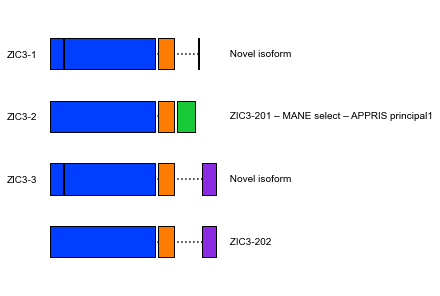

In [69]:
tfs['ZIC3'].exon_diagram()

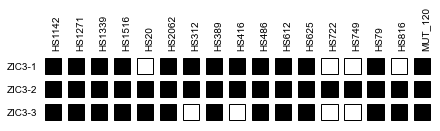

In [70]:
y1h_pdi_per_tf_gene_plot('ZIC3', y1h)

In [71]:
tfs['EBF3'].orfs[0].dna_binding_domains

[Pfam_domain: PF16422 COE1_DBD 17-247, Pfam_domain: PF01833 TIG 263-345]

In [72]:
df.loc[df['dbd_affected'].str.startswith('Full'), :].sort_values('delta_pdi')

,gene,ref_iso,alt_iso,dbd_fraction,dbd_insertion_n_aa,dbd_n_aa_to_change,dbd_flank_affected,dbd_pct_lost,dbd_affected,dbd_or_flank_affected,delta_pdi,tf_family,delta_pdi_trunc,tf_family_merged,full_PDI_loss,delta_n_aa,abs_delta_n_aa,delta_n_aa_disordered,abs_delta_n_aa_disordered,delta_n_aa_ordered,abs_delta_n_aa_ordered,f_disorder_delta_aa,pdi_affected,delta_n_K_or_R,count_K_or_R_sliding_window,f_disorder_difference
32,CREB1,CREB1-2,CREB1-1,0.0,0,180,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.000000,bZIP,-1.000000,other,True,-14.0,14.0,10.0,10.0,-24.0,24.0,0.294118,True,3,0,1.000000
470,PPARG,PPARG-1,PPARG-3,0.0,0,2,True,0.0,Full DBD in\nalternative isoform,DBD flank affected,-1.000000,Nuclear receptor,-1.000000,Nuclear receptor,True,245.0,245.0,25.0,25.0,220.0,220.0,0.102041,True,-27,3,0.114286
630,TEAD2,TEAD2-1,TEAD2-2,1.0,0,0,True,100.0,Full loss\nof DBD,Full loss\nof DBD,-1.000000,TEA,-1.000000,other,True,128.0,128.0,48.0,48.0,80.0,80.0,0.375000,True,-21,4,0.440299
333,MYF6,MYF6-2,MYF6-1,0.0,0,60,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.000000,bHLH,-1.000000,bHLH,True,-75.0,75.0,-93.0,93.0,18.0,18.0,0.837838,True,18,2,0.831858
320,MLX,MLX-1,MLX-3,0.0,0,20,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.000000,bHLH,-1.000000,bHLH,True,30.0,30.0,34.0,34.0,-4.0,4.0,0.894737,True,-2,2,1.000000
309,MEOX1,MEOX1-1,MEOX1-3,1.0,0,0,True,100.0,Full loss\nof DBD,Full loss\nof DBD,-1.000000,Homeodomain,-1.000000,Homeodomain,True,185.0,185.0,142.0,142.0,43.0,43.0,0.767568,True,-24,4,0.798122
306,MEOX1,MEOX1-1,MEOX1-2,0.0,0,57,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.000000,Homeodomain,-1.000000,Homeodomain,True,115.0,115.0,116.0,116.0,-1.0,1.0,0.991453,True,-7,3,1.000000
563,STAT3,STAT3-1,STAT3-3,0.0,0,227,False,0.0,Full DBD in\nalternative isoform,Full DBD in\nalternative isoform,-1.000000,STAT,-1.000000,other,True,97.0,97.0,-6.0,6.0,103.0,103.0,0.055046,True,-9,3,0.010101
255,KLF7,KLF7-1,KLF7-7,1.0,0,0,True,100.0,Full loss\nof DBD,Full loss\nof DBD,-1.000000,C2H2 ZF,-1.000000,C2H2 ZF,True,215.0,215.0,121.0,121.0,94.0,94.0,0.562791,True,-34,4,0.649254
253,KLF7,KLF7-1,KLF7-5,1.0,0,0,True,100.0,Full loss\nof DBD,Full loss\nof DBD,-1.000000,C2H2 ZF,-1.000000,C2H2 ZF,True,72.0,72.0,-50.0,50.0,122.0,122.0,0.290698,True,-20,4,0.392000


In [73]:
tfs['PPARG'].genomic_alignment_of_aa_seqs()

{'PPARG-1': 'MGETLGDSPIDPESDSFTDTLSANISQEMTMVDTEMPFWPTNFGISSVDLSVMEDHSHSFDIKPFTTVDFSSISTPHYEDIPFTRTDPVVADYKYDLKLQEYQSAIKVEPASPPYYSEKTQLYNKPHEEPSNSLMAIECRVCGDKASGFHYGVHACEGCKGFFRRTIRLKLIYDRCDLNCRIHKKSRNKCQYCRFQKCLAVGMSHN--------AIRFGRMPQAEKEKLLAEISSDIDQLNPESADLRALAKHLYDSYIKSFPLTKAKARAILTGKTTDKSPFVIYDMNSLMMGEDKIKFKHITPLQEQSKEVAIRIFQGCQFRSVEAVQEITEYAKSIPGFVNLDLNDQVTLLKYGVHEIIYTMLASLMNKDGVLISEGQGFMTREFLKSLRKPFGDFMEPKFEFAVKFNALELDDSDLAIFIAVIILSGD-R-P-G-L-LNVKPIEDIQDNLLQALELQLKLNHPESSQLFAKLLQKMTDLRQIVTEHVQLLQVIKKTETDMSLHPLLQEIYKDLY',
 'PPARG-2': '----------------------------MTMVDTEMPFWPTNFGISSVDLSVMEDHSHSFDIKPFTTVDFSSISTPHYEDIPFTRTDPVVADYKYDLKLQEYQSAIKVEPASPPYYSEKTQLYNKPHEEPSNSLMAIECRVCGDKASGFHYGVHACEGCKGFFRRTIRLKLIYDRCDLNCRIHKKSRNKCQYCRFQKCLAVGMSHN--------AIRFGRMPQAEKEKLLAEISSDIDQLNPESADLRALAKHLYDSYIKSFPLTKAKARAILTGKTTDKSPFVIYDMNSLMMGEDKIKFKHITPLQEQSKEVAIRIFQGCQFRSVEAVQEITEYAKSIPGFVNLDLNDQVTLLKYGVHEIIYTMLASLMNKDGVLISEGQGFMTREFLKSLRKPFGDFMEPKFEFAVKFNALELDDSDLAIFIAVIILSGD-R-P-G-L-LNVKPIEDIQDN

In [74]:
# load DNA bait sequnces
# look for E-box within HS385 / HS416 / MUT_116
baits = load_Y1H_DNA_bait_sequences()

In [75]:
y1h = load_y1h_pdi_data()

In [85]:
# DEBUG
y1h.tail().dtypes

tf             object
unique_acc     object
HS1022        boolean
HS1043        boolean
HS1067        boolean
               ...   
TNFSF14       boolean
TNFSF4        boolean
TNFSF8        boolean
XCL1          boolean
XCL2          boolean
Length: 200, dtype: object

In [92]:
def baits_set(row):
    return set(row.columns[2:].values[row.iloc[0, 2:].fillna(False).values])


df = y1h.groupby(['tf', 'unique_acc']).apply(baits_set).rename('baits').reset_index()


def is_differential(gene):
    non_zero = (frozenset(x) for x in gene['baits'].values if len(x) > 0)
    return len(set(non_zero)) >= 2

df = df.loc[df['tf'].map(df.groupby('tf').apply(is_differential))]
df['baits'] = df['baits'].apply(lambda x: ' '.join(x))
df.to_csv('../output/Y1H_differential-subset.tsv', index=False, sep='\t')

In [93]:
df['tf'].unique()

array(['DLX4', 'EBF3', 'FLI1', 'FOXP3', 'GRHL3', 'HEY1', 'HNF4A', 'KLF12',
       'LCOR', 'LHX9', 'MAX', 'NFIC', 'NFIX', 'PKNOX1', 'PPARG', 'PRRX1',
       'RARG', 'RORC', 'RXRG', 'STAT1', 'TBX5', 'TBX6', 'TCF4', 'TFAP2A',
       'TGIF1', 'THRA', 'THRB', 'WT1', 'ZIC3'], dtype=object)

In [95]:
# look for E-box within hs385 / hs416 / MUT_116

# Ebox is CANNTG

#re.search('CA..TG', baits['MUT_116'])
re.findall('CA..TG', baits['hs416'])

['CACATG', 'CATTTG', 'CATTTG']

In [96]:
re.findall('CA..TG', baits['hs385'])

['CAGCTG',
 'CAGCTG',
 'CAAATG',
 'CAGCTG',
 'CAGATG',
 'CACCTG',
 'CATTTG',
 'CAAATG',
 'CACTTG',
 'CATGTG']

In [97]:
baits['hs385']

'ATCCTGTCCAGCTGAGCGTAGACGGCAGTAGCCAGGGACTGGCAGCACAGGCTGTGTGACCGGGGCAGGGCTGGGAGAGAAAATGGCCGCCCTGTCGCCAGGTCCTTCTGTGTGTGGCCCTGTCAGGAAGGAGCCGGAGCTCCGGCCGGGGCTGGCTGGCTCCCGCTAAGTACTAACGCCACGGTGGCGGTGGGGGACAGGAGATGAGAGACAGAACAGGGCAGCTGCAAATGGAAATCACCCTAGGGAAGGTTACAACTAGATAAAGTTTTCGACAATAAGATTCCAGAGACTGCTGACGGGAGCAAAGCTCCGTATTTTAGTCTCAGTACAAATTTGCTTCAATCTTATACAACTCCCATGCAGCATTGCCCACAGCTGCATGCTGTAAACAACAAACAAATCTATTTCCATCAGCCCTGCTGATGCCAGGAGAAAAGTGCCTGAGCAGAAGACATGCACAGATGCAAACCCTCACCTGAGCCTGGCGCTGCCCTCCATTTGGCCTCTCTAACTTAATATCGTTGTTACAAAGCTATTGGTCTCCTGGTAGCTAGCTGGCTCAACGCAGTGCCTCTTCTTCCAGCTAATCTGACAACTCCGATCCAAGAAGCATCAAGGGCCCAATTAAGAAGACACATCTTATCAAGGAGCTTATTTTGCATAACAGAATACAAATGACGAATAAAAATTTAATGTTTAATAACTTAGTACAAAGAGGGCTGTTGATATAGAATGCCTGGAATTTTTATGGAGGCTGTCAGACTTGTGATAAAACTGTTATATAGGAACACTTGGCAAAAAACAGCGTAGAATTTTTCAGTAATGGTGTGTGCATGATATTGCATTAATTCTTGATAGGGAACTAACTGTAAGCCAGTTTGAGTTTCAGTGTAAGATGGTGTGTGTGTGTGCGTGCGTGTGTGTGTGTGCATGTGCGTGTGTGTGTCGTGCTCTATCCAGAATGCTCTGAGGGTGTGGCTGGACATGCACCCATGC

In [98]:
baits['hs416']

'ACGCACAGACACCCAATTTCCCATATACAGATAAATGCACACATGTATACGCGAAAGGTTAACTCGGCGGAGGACTCGCCCAAATAAGCACCGGATTGCATTTAAAATAATAATAATAAATAAATAAATAAACTAGGAAGGAAAGCGGGGGGAGGGAAGCAGAAGTCGGGAAGAAAAGAGAAAAGCAGCAGGCTGATTACGAGGTGTCAAAACTGCCAGGAGCAAGAAGGTGATAGCAATCAGGGGTGAGAAGAGTGCGGCATTCGTGCGGGGCAACTAATTATCCGTCTCATTTGAGAAGAGCAGCATTTGAGGCAGCAGCGTTCGCCTGCTGAACGGTGACAGATTGGCGCGGAGGAGAGGGGAGGTGTTAAAACAATGGAGCCGGGCGCGCGAGCGCTGCTGCATGCTAATCAGCCCTCCCTCCGCCTGCCTGCCGCGCTCCCTCCTTCCTCCCGGCCTCCCTCCTCCGCGCTCCCTCCTCCCGCCTGCGGCGCTCCCTCCTTTCCAGCGGGCCCCGCGCCGCCGCCGCCACCCGCTTCCTGCTCCCTCGCTT'

In [99]:
baits['MUT_116']

'GTGGCAGAGGACGGTGAGCGTGCGTGCGCGTGTGCGGGTGTGTGCGCGCCTGGGGAGGCGG'

In [100]:
re.findall('CG..TG', baits['MUT_116'])

['CGCGTG', 'CGGGTG', 'CGCCTG']

In [101]:
re.findall('CG..TG', baits['hs385'])

['CGTGTG', 'CGTGTG']

In [102]:
re.findall('CG..TG', baits['hs416'])

['CGCCTG', 'CGCCTG', 'CGCCTG']